## Agricultural pests classification using transfer learning with VGG-16

> I will be changing the classification layer (Dense layer) of the model for it to be more task speccific.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ADL/assignment23aug/threepests.zip

Archive:  /content/drive/MyDrive/ADL/assignment23aug/threepests.zip
   creating: threepests/pests/
   creating: threepests/pests/ants/
  inflating: threepests/pests/ants/ant_(0).jpg  
  inflating: threepests/pests/ants/ant_(1).png  
  inflating: threepests/pests/ants/ant_(10).jpg  
  inflating: threepests/pests/ants/ant_(100).jpg  
  inflating: threepests/pests/ants/ant_(101).jpg  
  inflating: threepests/pests/ants/ant_(102).jpg  
  inflating: threepests/pests/ants/ant_(103).jpg  
  inflating: threepests/pests/ants/ant_(104).jpg  
  inflating: threepests/pests/ants/ant_(105).jpg  
  inflating: threepests/pests/ants/ant_(106).jpg  
  inflating: threepests/pests/ants/ant_(107).jpg  
  inflating: threepests/pests/ants/ant_(108).jpg  
  inflating: threepests/pests/ants/ant_(109).jpg  
  inflating: threepests/pests/ants/ant_(11).jpg  
  inflating: threepests/pests/ants/ant_(110).jpg  
  inflating: threepests/pests/ants/ant_(111).jpg  
  inflating: threepests/pests/ants/ant_(112).jpg  
  in

## Load dataset

> This pests dataset is also used in the previous model, in part1normal.ipynb

In [ ]:
import tensorflow.keras as keras
import pandas as pd


path = 'threepests/pests/'
# Load in our data from CSV files
label_df = pd.read_csv(path+"pestsLabel.csv")


In [ ]:
print(f'Total number of images is {label_df.shape[0]}')
print(f'Number of classes is \n {label_df.label.value_counts()}')

Total number of images is 1415
Number of classes is 
 bees      500
ants      499
beetle    416
Name: label, dtype: int64


In [ ]:
label_df.head()

,images,label
0,ants/ant_(0).jpg,ants
1,ants/ant_(1).png,ants
2,ants/ant_(10).jpg,ants
3,ants/ant_(100).jpg,ants
4,ants/ant_(101).jpg,ants


### Spli data into training and test datasets 80:20

In [ ]:
# split data into training and test set
from sklearn.model_selection import train_test_split

train, test = train_test_split(label_df, test_size=0.2, random_state=0)

# Separate out our target values
y_train = train['label']
y_test = test['label']

# Separate out image paths
x_train = train['images']
x_test = test['images']

print('size of training set is ', len(x_train))
print('size of test set is ', len(x_test))

size of training set is  1132
size of test set is  283


#### Convert text labels into one hot encoded form

It is not enough to convert the labels into numbers, as this dataset contains more than 2 classes. Hence, to convert the labels into binary values, it is neccessary to perform one hot encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
print('Original labels: \n',y_train[:5])

# Fit and transform the label column
y_train_labelled = label_encoder.fit_transform(y_train)
y_test_labelled = label_encoder.fit_transform(y_test)
print('Transform labels into numerical values: ',y_train_labelled[:5])

# Turn our scalar targets into binary categories
num_classes = 3
y_train = keras.utils.to_categorical(y_train_labelled, num_classes)
y_test = keras.utils.to_categorical(y_test_labelled, num_classes)
print('Transform labels into binary categories: \n',y_train[:5])

Original labels: 
 535       bees
408       ants
609       bees
1266    beetle
880       bees
Name: label, dtype: object
Transform labels into numerical values:  [1 0 1 2 1]
Transform labels into binary categories: 
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


*   ants : 0
*   bees : 1
*   beetle : 2



## Preprocess images

1. Reshape images to be suitable for input to vgg16 model : 1, 224, 224, 3

In [ ]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    # print('Original image shape: ', mpimg.imread(image_path).shape)

    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(path+image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    # print('Processed image shape: ', image.shape)
    return image

In [ ]:
import numpy as np
import tensorflow as tf

# process training images
x_train_new = x_train.apply(lambda data:load_and_process_image(data))
trainbatch = np.stack(x_train_new, axis=0)
x_train = tf.reshape(trainbatch, shape=(-1, 224, 224, 3))

# process test images
x_test_new = x_test.apply(lambda data:load_and_process_image(data))
testbatch = np.stack(x_test_new, axis=0)
x_test = tf.reshape(testbatch, shape=(-1, 224, 224, 3))

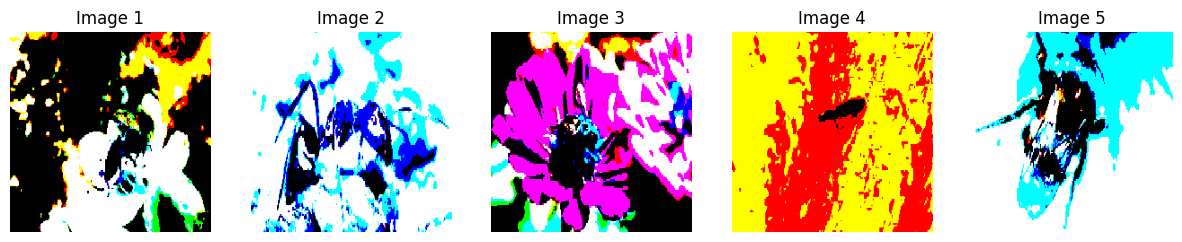

Shape of reshaped batch: (1132, 224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

# Display a few preprocessed images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.show()

print("Shape of reshaped batch:", x_train.shape)

In [ ]:
x_train.shape

TensorShape([1132, 224, 224, 3])

> The VGG16 model was originally trained using the Caffe library, which uses a BGR color scheme for reading images, rather than RGB

> Hence, the VGG16 image processing function has inverted the colours of the pictures from RGB to BGR.

### load the pre-trained model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

base_model.summary()

# vgg16 with imagenet weights produce the best reults
# trie inception v3 which is trained on insects

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### Freeze layers
We will not be retraining any layers for this use case

In [ ]:
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs)

x = keras.layers.Flatten()(x)
# A Dense classifier with a num_classes unit (multi-class classification)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

No need for data augmentation, as we will only be fine tuning the dense layers of the model

compile the model

In [ ]:
# use SGD as optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.85)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,  metrics=["accuracy"])

use early stoppingg callback to stop training when there is no improvement after x number of epochs

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, verbose=0,
    mode='auto', restore_best_weights=True)

### Train the model

In [ ]:
print(y_test.shape)
print(x_test.shape)
print(y_train.shape)
print(x_train.shape)

(283, 3)
(283, 224, 224, 3)
(1132, 3)
(1132, 224, 224, 3)


In [ ]:
batch_size = 32

hist = model.fit(x_train, y_train,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_test, y_test),
          callbacks=[earlystop_callback])

Epoch 1/20
35/35 [==============================] - 31s 523ms/step - loss: 290.6509 - accuracy: 0.8489 - val_loss: 179.1106 - val_accuracy: 0.9399
Epoch 2/20
35/35 [==============================] - 6s 173ms/step - loss: 66.2991 - accuracy: 0.9682 - val_loss: 272.9979 - val_accuracy: 0.9399
Epoch 3/20
35/35 [==============================] - 6s 169ms/step - loss: 13.4659 - accuracy: 0.9903 - val_loss: 172.9674 - val_accuracy: 0.9505
Epoch 4/20
35/35 [==============================] - 6s 171ms/step - loss: 7.1614 - accuracy: 0.9912 - val_loss: 294.6004 - val_accuracy: 0.9187
Epoch 5/20
35/35 [==============================] - 6s 172ms/step - loss: 17.1297 - accuracy: 0.9885 - val_loss: 256.6716 - val_accuracy: 0.9505
Epoch 6/20
35/35 [==============================] - 6s 175ms/step - loss: 11.0566 - accuracy: 0.9920 - val_loss: 281.1711 - val_accuracy: 0.9435
Epoch 7/20
35/35 [==============================] - 6s 178ms/step - loss: 1.4092 - accuracy: 0.9973 - val_loss: 303.3908 - val_ac

plot loss and validation loss comparison chart

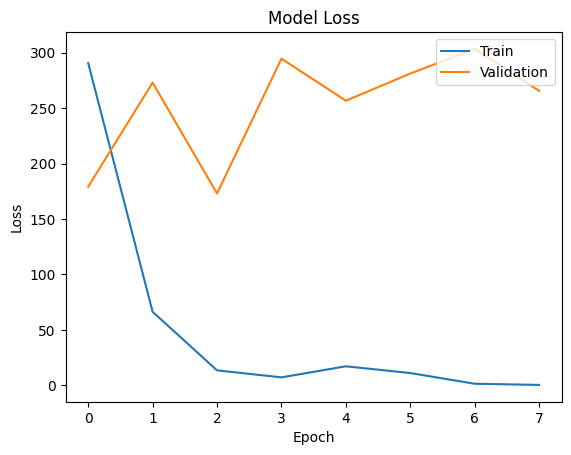

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plot accuracy and validation accuracy comparison chart

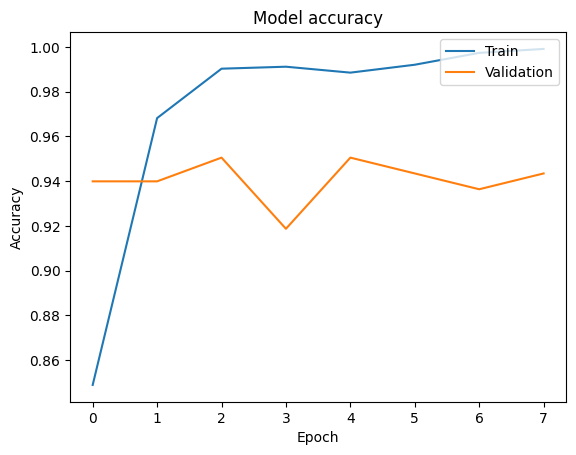

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

> Although there is a significant difference in the training loss and validation loss, there is only a slight difference in training and validation accuracy.

However, this may be indictive of the model overfitting.
The validation loss being much higher shows that the model is unable to generalize on the unseen data.
This is not shown in the validation accuracy as the validation data is very similar to the training data.

Evaluation

In [ ]:
from tensorflow.keras.preprocessing import image as image_utils


y_preds = []
y_labels = []
for i, img in enumerate(x_test[:100]):
    img = tf.reshape(img, shape=(1, 224, 224, 3))
    preds = model.predict(img)
    y_preds.append(np.argmax(preds))
    y_labels.append(y_test_labelled[i])


1/1 [==============================] - 0s 23ms/step


In [ ]:

from sklearn.metrics import classification_report

print(classification_report(y_labels, y_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       0.97      1.00      0.99        37
           2       1.00      0.92      0.96        25

    accuracy                           0.98       100
   macro avg       0.98      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100



> VGG16 model is shown to have the best performance, where training and validation accuracy is above 90%, and accuracy on the test dataset is 98%

> Previously, I had also tested inception v3 model, as it is known to have good performance in distinguishing between insects, with an F1 score of 0.75. However, the inception v3 model did not perform as well as the VGG16 model, even with the pre-trained weights from imagenet dataset.

> Conversely, the model returns very high accuracy on this test dataset, but may not perform well on other image datasets. As the model is shown to be overfitting in the training process, it may only be able to predict well on images that are similar to the training data used.

> This ovefitting may be caused by using large amount of data (1132 images), even without the use of data augmentation, to only train the dense layer of the VGG16 model. However, as the model achieves the purpose of the use case, to identify pests, I will not be making further tuning to the layers of the model.

---



---

